## Amazon Bedrock LLM Router Evaluation

### Intro and Goal
This Jupyter Notebook is designed to test an LLM (Large Language Model) routing system on a Text-to-SQL use case.

The goal is to take a prompt, determine the level of complexity and then route the prompt either to a small or large LLM to generate the corresponding SQL query.

The notebook is structured as follows:
1. Create a ground truth dataset comprised of questions and SQL queries for a given database (e.g. Northwind) (notebook 4a)
2. **Define Router (notebook 4b)**
3. **Evaluate accuracy, cost, and latency of LLM classifier router approach compared to the baseline of using a larger LLM for all queries. (notebook 4b)**

In [2]:
# 1. Create a conda environment

# !conda create -y --name bedrock-router-eval python=3.11.8
# !conda init && activate bedrock-router-eval
# !conda install -n bedrock-router-eval ipykernel --update-deps --force-reinstall -y
# !conda install -c conda-forge ipython-sql

In [3]:
# 2. Install dependencies

# !pip install -r requirements.txt

In [4]:
# 3. Import necessary libraries and load environment variables

import numpy as np
from scipy.spatial.distance import cdist
import json
from dotenv import load_dotenv, find_dotenv
import os
import boto3
import sqlite3
from pandas.io import sql
from botocore.config import Config
import pandas as pd
import io
import json
from io import StringIO
import sqlparse
import sqlite3
import time
import matplotlib.pyplot as plt
import re
import typing as t
from queue import Queue
from threading import Thread
from concurrent.futures import ThreadPoolExecutor, as_completed

# loading environment variables that are stored in local file
local_env_filename = 'bedrock-router-eval.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['REGION'] = os.getenv('REGION')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ['SQL_DATABASE'] = os.getenv('SQL_DATABASE') # LOCAL or GLUE
os.environ['SQL_DIALECT'] = os.getenv('SQL_DIALECT') # SQlite or awsathena
os.environ['SQL_DATABASE_NAME'] = os.getenv('SQL_DATABASE_NAME')
# os.environ['AWS_ACCESS_KEY'] = os.getenv('AWS_ACCESS_KEY')
# os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')

REGION = os.environ['REGION']
HF_TOKEN = os.environ['HF_TOKEN']
SQL_DATABASE = os.environ['SQL_DATABASE']
SQL_DIALECT = os.environ['SQL_DIALECT']
SQL_DATABASE_NAME = os.environ['SQL_DATABASE_NAME']

MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0" # anthropic.claude-3-haiku-20240307-v1:0 "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"
EVAL_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

# get ground truth data
file_path = 'data/eval-source/question_query_good_results.jsonl'
groundtruth_df = pd.read_json(file_path, lines=True)

In [5]:
# 4. Definition of helper classes

class BedrockLLMWrapper():
    def __init__(self,
        model_id: str = 'anthropic.claude-3-sonnet-20240229-v1:0', # 'anthropic.claude-3-haiku-20240307-v1:0', #'anthropic.claude-3-sonnet-20240229-v1:0',
        top_k: int = 5,
        top_p: int = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        max_attempts: int = 3,
        debug: bool = False

    ):

        self.model_id = model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.debug = debug
        config = Config(
            retries = {
                'max_attempts': 10,
                'mode': 'standard'
            }
        )

        self.bedrock_runtime = boto3.client(service_name="bedrock-runtime", config=config, region_name=REGION)
        
    def generate(self,prompt):
        if self.debug: 
            print('entered BedrockLLMWrapper generate')
        attempt = 1

        message = {
            "role": "user",
            "content": [{"text": prompt}]
        }
        messages = []
        messages.append(message)
        
        # model specific inference parameters to use.
        if "anthropic" in self.model_id.lower():
            # system_prompts = [{"text": "You are a helpful AI Assistant."}]
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                                "stopSequences": ["\n\nHuman:"],
                                "topP": self.top_p,
                            }
            additional_model_fields = {"top_k": self.top_k}
        else:
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                            }
            additional_model_fields = {"top_k": self.top_k}

        if self.debug: 
            print("Sending:\nSystem:\n",system,"\nMessages:\n",str(messages))

        while True:
            try:

                # Send the message.
                response = self.bedrock_runtime.converse(
                    modelId=self.model_id,
                    messages=messages,
                    system=system_prompts,
                    inferenceConfig=inference_config,
                    additionalModelRequestFields=additional_model_fields
                )

                # Log token usage.
                text = response['output'].get('message').get('content')[0].get('text')
                usage = response['usage']
                latency = response['metrics'].get('latencyMs')

                if self.debug: 
                    print(f'text: {text} ; and token usage: {usage} ; and query_time: {latency}')    
                
                break
               
            except Exception as e:
                print("Error with calling Bedrock: "+str(e))
                attempt+=1
                if attempt>self.max_attempts:
                    print("Max attempts reached!")
                    result_text = str(e)
                    break
                else:#retry in 10 seconds
                    print("retry")
                    time.sleep(10)

        # return result_text
        return [text,usage,latency]

     # Threaded function for queue processing.
    def thread_request(self, q, results):
        while True:
            try:
                index, prompt = q.get(block=False)
                data = self.generate(prompt)
                results[index] = data
            except Queue.Empty:
                break
            except Exception as e:
                print(f'Error with prompt: {str(e)}')
                results[index] = str(e)
            finally:
                q.task_done()

    def generate_threaded(self, prompts, max_workers=15):
        results = [None] * len(prompts)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_index = {executor.submit(self.generate, prompt): i for i, prompt in enumerate(prompts)}
            for future in as_completed(future_to_index):
                index = future_to_index[future]
                try:
                    results[index] = future.result()
                except Exception as exc:
                    print(f'Generated an exception: {exc}')
                    results[index] = str(exc)
        
        return results

class Util():
    def __init__(self,
        debug: bool = False

    ):
        self.debug = debug
    
    SCORE_PATTERN = r'<score>(.*?)</score>'
    REASONING_PATTERN = r'<thinking>(.*?)</thinking>'
    SQL_PATTERN = r'<sql>(.*?)</sql>'
    DIFFICULTY_PATTERN = r'<difficulty>(.*?)</difficulty>'
    USER_QUESTION_PATTERN = r'<user_question>(.*?)</user_question>'
    SQL_DATABASE_SCHEMA_PATTERN = r'<sql_database_schema>(.*?)</sql_database_schema>'
    SQL_DIALECT_PATTERN = r'<sql_dialect>(.*?)</sql_dialect>'


    def compare_results(self, answer_results1, answer_results2):


        # # Function to convert 'score' column
        def convert_score(df):
            # df['score'] = df['score'].map({'correct': 1, 'incorrect': 0})
            df['score'] = pd.to_numeric(df['score'], errors='coerce').fillna(0).astype(int)
            return df

        # Apply the conversion to both dataframes
        answer_results1 = convert_score(answer_results1)
        answer_results2 = convert_score(answer_results2)

        # Calculate the average values for each metric
        metrics = ['score', 'latency' ,'cost', 'ex_score', 'em_score','ves_score']
        
        avg_results1 = [answer_results1[metric].mean() for metric in metrics]
        avg_results2 = [answer_results2[metric].mean() for metric in metrics]

        # Calculate percentage change, handling divide-by-zero and infinite cases
        def safe_percent_change(a, b):
            if pd.isna(a) or pd.isna(b):
                return 0
            if a == 0 and b == 0:
                return 0
            elif a == 0:
                return 100  # Arbitrarily set to 100% increase if original value was 0
            else:
                change = (b - a) / a * 100
                return change if np.isfinite(change) else 0

        percent_change = [safe_percent_change(a, b) for a, b in zip(avg_results1, avg_results2)]

        # Set up the bar chart
        x = np.arange(len(metrics))
        width = 0.5

        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the bars
        bars = ax.bar(x, percent_change, width)

        # Customize the chart
        ax.set_ylabel('Percentage Change (%)')
        ax.set_title('Percentage Change in Metrics (Results 2 vs Results 1)')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)

        # Add a horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        # Add value labels on top of each bar
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}%',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3 if height >= 0 else -3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom' if height >= 0 else 'top')

        autolabel(bars)

        # Color the bars based on positive (green) or negative (red) change
        # For latency & cost, reverse the color logic
        for bar, change, metric in zip(bars, percent_change, metrics):
            if metric == 'latency' or metric == 'cost':
                bar.set_color('green' if change <= 0 else 'red')
            else:
                bar.set_color('green' if change >= 0 else 'red')
            

        # Adjust layout and display the chart
        fig.tight_layout()
        plt.show()

    def visualize_distribution(self, df, key):
        # Check if 'score' column exists in the DataFrame
        if key not in df.columns:
            raise ValueError(f"The DataFrame does not contain a '{key}' column.")
        
        # Count the frequency of each score
        score_counts = df[key].value_counts().sort_index()
        
        # Create a bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(score_counts.index, score_counts.values)
        
        # Customize the chart
        plt.title(f'Distribution of {key}')
        plt.xlabel(f'{key}')
        plt.ylabel('Frequency')
        plt.xticks(range(int(score_counts.index.min()), int(score_counts.index.max()) + 1))
        
        # Add value labels on top of each bar
        for i, v in enumerate(score_counts.values):
            plt.text(score_counts.index[i], v, str(v), ha='center', va='bottom')
        
        # Display the chart
        plt.tight_layout()
        plt.show()

    # Strip out the portion of the response with regex.
    def extract_with_regex(self, response, regex):
        matches = re.search(regex, response, re.DOTALL)
        # Extract the matched content, if any
        return matches.group(1).strip() if matches else None

    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        
        input_token_titan_embeddingv1 = 0.1/1000000
        input_token_titan_embeddingv2 = 0.02/1000000
        input_token_titan_embeddingmultimodal = 0.8/1000000
        input_token_titan_premier = 0.5/1000000
        output_token_titan_premier = 1.5/1000000
        input_token_titan_lite = 0.15/1000000
        output_token_titan_lite = 0.2/1000000
        input_token_titan_express = 0.2/1000000
        output_token_titan_express = 0.6/1000000
       
        input_token_cohere_command = 0.15/1000000
        output_token_cohere_command = 2/1000000
        input_token_cohere_commandlight = 0.3/1000000
        output_token_cohere_commandlight = 0.6/1000000
        input_token_cohere_commandrplus = 3/1000000
        output_token_cohere_commandrplus = 15/1000000
        input_token_cohere_commandr = 5/1000000
        output_token_cohere_commandr = 1.5/1000000
        input_token_cohere_embedenglish = 0.1/1000000
        input_token_cohere_embedmultilang = 0.1/1000000

        input_token_llama3_8b = 0.4/1000000
        output_token_llama3_8b = 0.6/1000000
        input_token_llama3_70b = 2.6/1000000
        output_token_llama3_70b = 3.5/1000000

        input_token_mistral_8b = 0.15/1000000
        output_token_mistral_8b = 0.2/1000000
        input_token_mistral_large = 4/1000000
        output_token_mistral_large = 12/1000000

        cost = 0

        if 'haiku' in model_id:
            cost+= usage['inputTokens']*input_token_haiku
            cost+= usage['outputTokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['inputTokens']*input_token_sonnet
            cost+= usage['outputTokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['inputTokens']*input_token_opus
            cost+= usage['outputTokens']*output_token_opus
        if 'amazon.titan-embed-text-v1' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv1
        if 'amazon.titan-embed-text-v2' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv2
        if 'cohere.embed-multilingual' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedmultilang
        if 'cohere.embed-english' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedenglish 
        if 'meta.llama3-8b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_8b
            cost+= usage['outputTokens']*output_token_llama3_8b
        if 'meta.llama3-70b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_70b
            cost+= usage['outputTokens']*output_token_llama3_70b
        if 'cohere.command-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_command
            cost+= usage['outputTokens']*output_token_cohere_command
        if 'cohere.command-light-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandlight
            cost+= usage['outputTokens']*output_token_cohere_commandlight
        if 'cohere.command-r-plus' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandrplus
            cost+= usage['outputTokens']*output_token_cohere_commandrplus
        if 'cohere.command-r' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandr
            cost+= usage['outputTokens']*output_token_cohere_commandr
        if 'amazon.titan-text-express' in model_id:
            cost+= usage['inputTokens']*input_token_titan_express
            cost+= usage['outputTokens']*output_token_titan_express
        if 'amazon.titan-text-lite' in model_id:
            cost+= usage['inputTokens']*input_token_titan_lite
            cost+= usage['outputTokens']*output_token_titan_lite
        if 'amazon.titan-text-premier' in model_id:
            cost+= usage['inputTokens']*input_token_titan_premier
            cost+= usage['outputTokens']*output_token_titan_premier
        if 'mistral.mixtral-8x7b-instruct-v0:1' in model_id:
            cost+= usage['inputTokens']*input_token_mistral_8b
            cost+= usage['outputTokens']*output_token_mistral_8b

        return cost


class AnswerTaskRunner:
    def __init__(self, eval_df: pd.DataFrame, 
                 model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 eval_model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 routeLLM=None,
                 conn=None,
                 sql_dialect=None,
                 temperature: float = 0.0,
                 max_token_count: int = 2000,
                 max_attempts: int = 3, 
                 prompt_template: str = '',
                 prompt_eval_template: str = ''):
        self.eval_df = eval_df
        self.model_id = model_id
        self.eval_model_id = eval_model_id
        self.routeLLM = routeLLM
        self.conn = conn
        self.sql_dialect = sql_dialect
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.prompt_template = prompt_template
        self.prompt_eval_template = prompt_eval_template
        self.wrapper = BedrockLLMWrapper(model_id=self.model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )
        self.eval_wrapper = BedrockLLMWrapper(model_id=self.eval_model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )
        self.util = Util()


    def get_prompt(self, user_question, sql_database_schema,sql_dialect):
        prompt = self.prompt_template.format(
                    user_question=user_question,
                    sql_database_schema=sql_database_schema,
                    sql_dialect=self.sql_dialect
                ) 
        return prompt


    def build_grader_prompt(self, 
                            question: str, 
                            sql_schema: str, 
                            sql_query:str, 
                            sql_query_run_error, 
                            sql_query_run_result:str,
                            groundtruth_sql_query:str,
                            ex_score:str,
                            em_score:str,
                            ves_score:str):
    
        prompt = self.prompt_eval_template.format(
                    question=question,
                    sql_schema=sql_schema,
                    sql_query= sql_query,
                    sql_query_run_error= sql_query_run_error,
                    sql_query_run_result= sql_query_run_result,
                    groundtruth_sql_query= groundtruth_sql_query,
                    ex_score=ex_score,
                    em_score=em_score,
                    ves_score=ves_score,
                ) 
        return prompt


    def execution_accuracy(self, generated_sql, labeled_sql):
        """
        Calculate Execution Accuracy (EX)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        
        Returns:
        float: 1.0 if the queries match, 0.0 otherwise
        """
        # Normalize and compare the SQL queries
        gen_normalized = sqlparse.format(generated_sql, strip_comments=True, reindent=True)
        lab_normalized = sqlparse.format(labeled_sql, strip_comments=True, reindent=True)
        
        return 1.0 if gen_normalized == lab_normalized else 0.0


    def exact_set_match_accuracy(self, generated_sql, labeled_sql, db_connection):
        """
        Calculate Exact Set Match Accuracy (EM)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        db_connection: A database connection object
        
        Returns:
        float: 1.0 if the result sets match, 0.0 otherwise
        """
        try:
            # Execute both queries
            gen_result = pd.read_sql_query(generated_sql, db_connection)
            lab_result = pd.read_sql_query(labeled_sql, db_connection)
            
            # Compare the result sets
            return 1.0 if gen_result.equals(lab_result) else 0.0
        except Exception as e:
            print(f"Error executing SQL: {e}")
            return 0.0


    def valid_efficiency_score(self, generated_sql, labeled_sql, db_connection):
        """
        Calculate Valid Efficiency Score (VES)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        db_connection: A database connection object
        
        Returns:
        float: The VES score
        """
        try:
            # Execute both queries and measure execution time
            gen_start = time.time()
            gen_result = pd.read_sql_query(generated_sql, db_connection)
            gen_time = time.time() - gen_start
            # print(f'generated_sql_execution_time: {gen_time}')
            lab_start = time.time()
            lab_result = pd.read_sql_query(labeled_sql, db_connection)
            lab_time = time.time() - lab_start
            # print(f'labeled_sql_execution_time: {lab_time}')
            
            # Check if results match
            if not gen_result.equals(lab_result):
                return 0.0
            
            # Calculate VES
            ves = min(lab_time / gen_time, 1.0)
            return ves
        except Exception as e:
            print(f"Error executing SQL: {e}")
            return 0.0


    def run(self) -> pd.DataFrame:
        # Make a copy of the dataframe so we don't modify the original.
        df = pd.DataFrame(self.eval_df)
        results = []
        
        # Prepare prompts for all questions
        prompts = []
        for _, row in df.iterrows():
            question: str = row['Question']
            sql_database_schema: str = row['Context']
            model_prompt = self.get_prompt(question, sql_database_schema, self.sql_dialect)
            prompts.append(model_prompt)
        
        # Generate SQL queries using threaded approach
        if self.routeLLM:
            answers = self.routeLLM.generate_threaded(prompts)
            
        else:
            answers = self.wrapper.generate_threaded(prompts)
        
        # bottleneck: from here on we are back to processing in sequence
        for index, (answer, row) in enumerate(zip(answers, df.iterrows())):
            _, row = row  # Unpack the row
            question: str = row['Question']
            sql_database_schema: str = row['Context']
            groundtruth_sql_query: str = row['Query']
            
            if self.routeLLM:
                # use router if provided
                classification_result = answer[0]
                response = answer[1]

                classification = self.util.extract_with_regex(str(classification_result[0]), self.util.DIFFICULTY_PATTERN)
                answer = response
                if classification == 1:
                    latency = classification_result[2]
                    cost = self.util.calculate_cost(classification_result[1], routeLLM.small_llm_model_id)
                    usage = json.dumps(classification_result[1])
                else:
                    latency = classification_result[2] + response[2]
                    cost = self.util.calculate_cost(classification_result[1], routeLLM.small_llm_model_id) + self.util.calculate_cost(response[1], routeLLM.large_llm_model_id)
                    usage = json.dumps([classification_result[1],response[1]])

            else:
                cost = self.util.calculate_cost(answer[1], self.model_id)
                latency = answer[2]
                usage = json.dumps(answer[1])
            
            generated_sql_query = self.util.extract_with_regex(str(answer[0]), self.util.SQL_PATTERN).replace("\\","")
            
            # Calculate eval metrics
            cursor = self.conn.cursor()
            sql_query_run_error = None
            sql_query_run_result = None
            try:
                if SQL_DATABASE == 'LOCAL':
                    try:
                        cursor.execute(generated_sql_query)
                        sql_query_run_result = cursor.fetchall()
                    except sqlite3.Error as e:
                        print(f"Error executing statement: {e}")
                        sql_query_run_error = e
                else:
                    sql_query_run_result = execute_athena_query(DATABASE, row.Query)
            except ClientError as e:
                sql_query_run_error = e
            
            ex_score = self.execution_accuracy(generated_sql_query, groundtruth_sql_query)
            em_score = self.exact_set_match_accuracy(generated_sql_query, groundtruth_sql_query, self.conn)
            ves_score = self.valid_efficiency_score(generated_sql_query, groundtruth_sql_query, self.conn)
            
            # Create eval prompt
            prompt = self.build_grader_prompt(question=question, 
                                            sql_schema=sql_database_schema, 
                                            sql_query=generated_sql_query, 
                                            sql_query_run_error=sql_query_run_error,
                                            sql_query_run_result=sql_query_run_result,
                                            groundtruth_sql_query=groundtruth_sql_query,
                                            ex_score=ex_score,
                                            em_score=em_score,
                                            ves_score=ves_score)
            
            # Parse eval results
            eval_result = self.eval_wrapper.generate(prompt)
            reasoning = self.util.extract_with_regex(str(eval_result[0]), self.util.REASONING_PATTERN)
            score = self.util.extract_with_regex(str(eval_result[0]), self.util.SCORE_PATTERN)
            
            # Create new record
            result = {
                'user_question': question,
                'groundtruth_query': groundtruth_sql_query,
                'generated_sql_query': generated_sql_query,
                'score': score,
                'reasoning': reasoning,
                'usage': usage,
                'latency': latency,
                'cost': cost,
                'ex_score': ex_score,
                'em_score': em_score,
                'ves_score': ves_score,
                'sql_query_run_error': sql_query_run_error,
                'sql_query_run_result': sql_query_run_result,
                'context': sql_database_schema,
            }
            results.append(result)
        
        new_dataframe = pd.DataFrame(results)
        return new_dataframe

### Define Router

In [6]:
# 6. LLM Router definiton
class RouteLLMWrapper():
    def __init__(self,
        small_llm_model_id: str = 'mistral.mixtral-8x7b-instruct-v0:1',
        large_llm_model_id: str = 'anthropic.claude-3-sonnet-20240229-v1:0',
        route_prompt_template: str = '',
        sql_template: str = ''
    ):
        self.small_llm_model_id = small_llm_model_id
        self.large_llm_model_id = large_llm_model_id
        self.small_llm = BedrockLLMWrapper(debug=False, model_id=self.small_llm_model_id, max_token_count=512)
        self.large_llm = BedrockLLMWrapper(debug=False, model_id=self.large_llm_model_id, max_token_count=512)
        self.route_prompt_template = route_prompt_template
        self.sql_template = sql_template
        self.util = Util()
        

    def generate(self, prompt):
        # 1. Classify prompt and if simple, answer right away
        print('routeLLM generate')
        user_question=self.util.extract_with_regex(prompt, self.util.USER_QUESTION_PATTERN)
        sql_database_schema=self.util.extract_with_regex(prompt, self.util.SQL_DATABASE_SCHEMA_PATTERN) 
        sql_dialect=self.util.extract_with_regex(prompt, self.util.SQL_DIALECT_PATTERN)
        if sql_dialect == None or sql_dialect=='':
            sql_dialect = 'SQlite' #default
        print(f'routeLLM sql_dialect: {sql_dialect}')
        classification_prompt = self.route_prompt_template.format(
                                        user_question=user_question,
                                        sql_database_schema=sql_database_schema,
                                        sql_dialect=sql_dialect
                                    )
        classification_value = 3 # default to larger LLM
        classification_result = self.small_llm.generate(classification_prompt)
        classification_value = self.util.extract_with_regex(classification_result[0], self.util.DIFFICULTY_PATTERN)
        if classification_value is not None:
            classification_value = int(classification_value)
            result = classification_result
        else:
            print(f'classification value is None for: {classification_result}')
        # route questions that have been rated more difficult to larger LLM and overwrite small llm result
        
        if classification_value > 1:
            sql_prompt = self.sql_template.format(user_question=user_question,
                                        sql_database_schema=sql_database_schema,
                                        sql_dialect=sql_dialect)
            result = self.large_llm.generate(sql_prompt) # invoke large LLM
                 
        return classification_result, result
    
    def generate_threaded(self, prompts, max_workers=15):
        results = [None] * len(prompts)
        print('routeLLM threaded')
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_index = {executor.submit(self.generate, prompt): i for i, prompt in enumerate(prompts)}
            for future in as_completed(future_to_index):
                index = future_to_index[future]
                try:
                    results[index] = future.result()
                except Exception as exc:
                    print(f'Generated an exception: {exc}')
                    results[index] = str(exc)
        
        return results


In [7]:
# 7. SQL generation prompt

sql_template = """You are a SQL expert. You will be provided with the original user question and a SQL database schema. 
                Only return the SQL query and nothing else.
                
                User question:
                <user_question>
                {user_question}
                </user_question>

                SQL database schema:
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                SQL dialect:
                <sql_dialect>
                {sql_dialect}
                </sql_dialect>

                Instructions:
                Generate a SQL query that answers the original user question.
                Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
                Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
                Pay attention to use only the column names that you can see in the schema description. 
                Be careful to not query for columns that do not exist. 
                Pay attention to which column is in which table. 
                Also, qualify column names with the table name when needed.
                If you cannot answer the user question with the help of the provided SQL database schema, 
                then output that this question question cannot be answered based of the information stored in the database.
                You are required to use the following format, each taking one line:
                Return the sql query inside the <sql></sql> tab.
                """

In [8]:
# 8. router template
route_prompt_template="""                       
                        Instructions:
                        1. Give this question a difficulty rating from 1 to 3, where 3 is the most difficult and 1 is the easiest.
                        2. Return the difficulty inside <difficulty></difficulty> tags. 
                        3. If the score is 1, then generate the SQL query to answer the question.
                        4. Return the generated SQL qery inside <sql></sql> tags.
                        5. Review your formatted response. It needs to be valid XML.
                        
                        Question:
                        <user_question>
                        {user_question}
                        </user_question>

                        SQL database schema for the SQL dialect {sql_dialect}:
                        <sql_database_schema>
                        {sql_database_schema}
                        </sql_database_schema>
                        """

In [9]:
# 10. test router
sql_dialect='SQlite'
routeLLM = RouteLLMWrapper(route_prompt_template=route_prompt_template,sql_template=sql_template)
prompt = sql_template.format(
                    user_question=groundtruth_df[:1]['Question'],
                    sql_database_schema=groundtruth_df[:1]['Context'],
                    sql_dialect=sql_dialect
                ) 

result = routeLLM.generate_threaded([prompt])
print(result[0])

routeLLM threaded
routeLLM generate
routeLLM sql_dialect: SQlite
([' <difficulty>1</difficulty>\n<sql>\nSELECT COUNT(*) FROM customers;\n</sql>', {'inputTokens': 240, 'outputTokens': 29, 'totalTokens': 269}, 745], [' <difficulty>1</difficulty>\n<sql>\nSELECT COUNT(*) FROM customers;\n</sql>', {'inputTokens': 240, 'outputTokens': 29, 'totalTokens': 269}, 745])


### Evaluation

In [10]:
# 11. Grading prompt

evaluation_template = """You are a SQL expert. 
                Your task is to evaluate a given SQL query based on a provided SQL schema and question using the criteria provided below.
 
                Evaluation Criteria (Additive Score, 0-5):
                1. Context: Award 1 point if the generated SQL query uses only information provided in the SQL schema, without introducing external or fabricated details.
                2. Completeness: Add 1 point if the generated SQL query addresses all key elements of the question based on the available SQL schema and Exact Set Match Accuracy (EM) score.
                3. ExecutionAccuracy: Add 1 point if the generated SQL query is very close to the groundtruth answer based on Execution Accuracy score.
                4. Faultless: Add 1 point if the generated SQL query ran without any errors.
                5. ValidEfficiencyScore:  Add 1 point if the runtime of the generated SQL query is similar or better than the the groundtruth qery as measured by the Valid Efficiency Score (VES).
                
                Evaluation Steps:
                1. Read provided context, question and answer carefully.
                2. Go through each evaluation criterion one by one and assess whether the answer meets the criteria.
                3. Compose your reasoning for each critera, explaining why you did or did not award a point. You can only award full points. 
                4. Calculate the total score by summing the points awarded.
                5. Think through the evaluation criteria inside <thinking></thinking> tags. 
                Then, output the total score inside <score></score> tags.
                Review your formatted response. It needs to be valid XML.
    
                Original question:
                <question>
                {question}
                </question>

                SQL schema:
                <sql_schema>
                {sql_schema}
                </sql_schema>

                Generated SQL query based on these instructions:
                <sql_query>
                {sql_query}
                </sql_query>

                SQL result based on the generated SQL query:
                <sql_query_run_result>
                {sql_query_run_result}
                </sql_query_run_result>

                Any SQL errors that might have occured based on the generated SQL query:
                <sql_query_run_error>
                {sql_query_run_error}
                </sql_query_run_error>

                Groundtruth SQL query for comparison with the generated SQL query:
                <groundtruth_sql_query>
                {groundtruth_sql_query}
                </groundtruth_sql_query>
                
                Execution Accuracy, which compares the generated SQL query to the labeled SQL query to determine if its a match or not: 
                <ex_score>
                {ex_score}
                </ex_score>
                
                Exact Set Match Accuracy (EM), which evaluates if the returned result set actually answer the question, regardless of how the query was written: 
                <em_score>
                {em_score}
                </em_score>

                Valid Efficiency Score (VES), which compares the runtime of the SQL provided as groundtruth to the generated SQL query:
                <ves_score>
                {ves_score}
                </ves_score>                
                """

In [11]:
# 12. Run eval of LLM Router

# Create a SQLite database connection
conn = sqlite3.connect('routedb.db')

answer_results1: pd.DataFrame = AnswerTaskRunner(groundtruth_df,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 routeLLM=routeLLM,
                 conn=conn,
                 sql_dialect=sql_dialect,
                 prompt_template=sql_template,
                 prompt_eval_template=evaluation_template).run()
answer_results1.to_json('data/eval-results/4_router-eval-graded1.jsonl', orient='records', lines=True)

routeLLM threaded
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQlite
routeLLM generate
routeLLM sql_dialect: SQ

In [12]:
# 13. Run eval of larger LLM 

# Create a SQLite database connection
conn = sqlite3.connect('routedb.db')

answer_results2: pd.DataFrame = AnswerTaskRunner(groundtruth_df,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                #  routeLLM=routeLLM,
                 conn=conn,
                 sql_dialect=sql_dialect,
                 prompt_template=sql_template,
                 prompt_eval_template=evaluation_template).run()
answer_results2.to_json('data/eval-results/4_router-eval-graded2.jsonl', orient='records', lines=True)

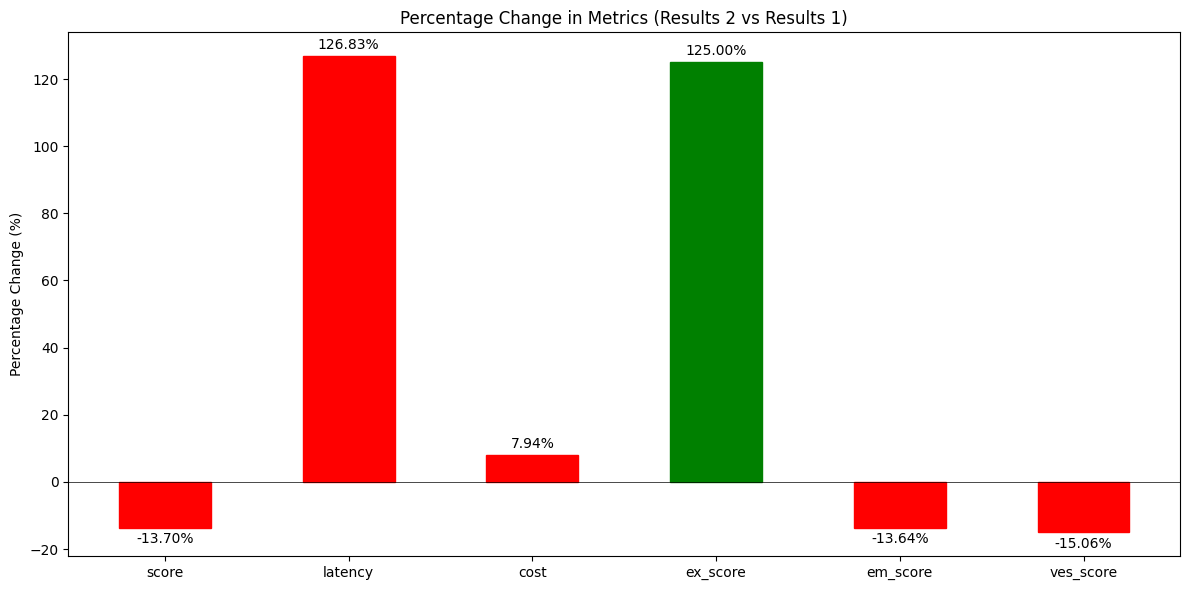

In [13]:
# 14. Compare results

util = Util()
util.compare_results(answer_results2, answer_results1)

In [14]:
# 15. Review results
print(f'sum of small_cost: {answer_results1["cost"].sum()}')
print(f'sum of large_cost: {answer_results2["cost"].sum()}')

print(f'avg of small_query_time: {answer_results1["latency"].mean()}')
print(f'avg of large_query_time: {answer_results2["latency"].mean()}')

# Execution Accuracy, which compares the generated router SQL query to the SQL query generated by the larger LLM to determine if its a match
print(f'avg of ex_score of answer_results1: {answer_results1["ex_score"].mean()}')
# Exact Set Match Accuracy (EM), which evaluates if the generated router SQL query resultset matches the SQL query generated resultset by the larger LLM
print(f'avg of em_scoreof answer_results: {answer_results1["em_score"].mean()}')
# Valid Efficiency Score (VES), which compares the  generated router SQL query runtime provided to the generated SQL query from the larger LLM
print(f'avg of ves_score of answer_results1: {answer_results1["ves_score"].mean()}')

sum of small_cost: 0.91875205
sum of large_cost: 0.851148
avg of small_query_time: 6440.236486486487
avg of large_query_time: 2839.2905405405404
avg of ex_score of answer_results1: 0.060810810810810814
avg of em_scoreof answer_results: 0.12837837837837837
avg of ves_score of answer_results1: 0.11146668372074867


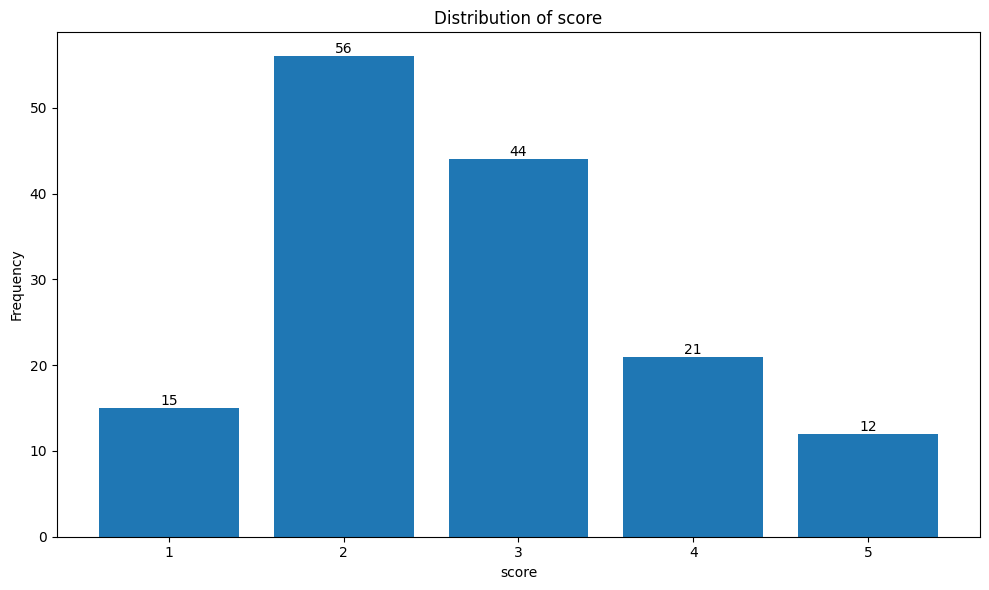

In [15]:
# 16. Distribution of RouteLLM results
util.visualize_distribution(answer_results1,key='score')

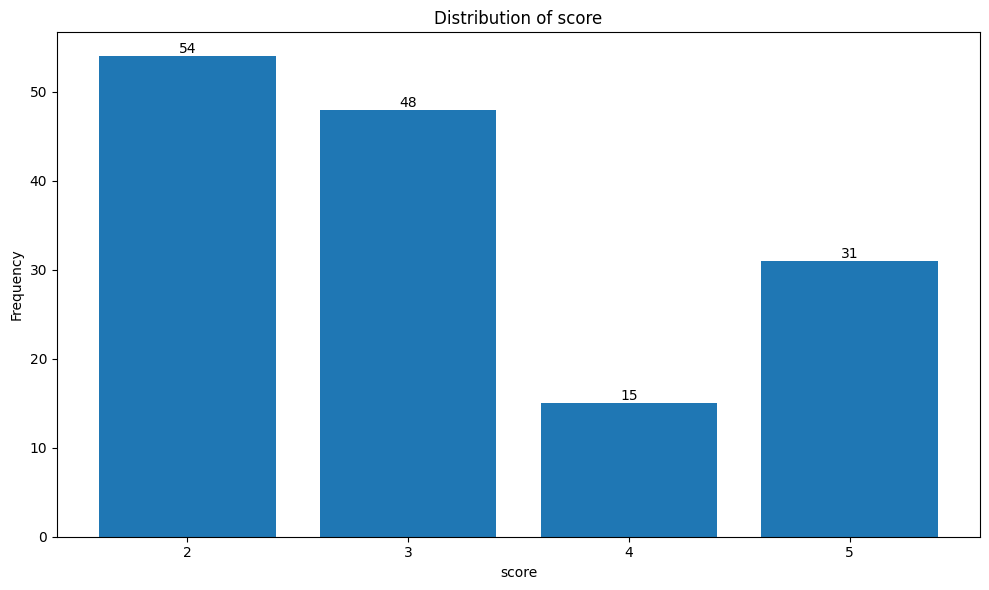

In [16]:
# 17. Distribution of largeLLM results
util.visualize_distribution(answer_results2,key='score')

### Conclusion
XXX